In [25]:
import os
import jax.numpy as jnp
import equinox as eqx

from jax import random
from jax.nn import relu, sigmoid

import numpy as np
import jax.numpy as jnp
import struct
import optax
import diffrax
import equinox as eqx
import time
import sys
import matplotlib.pyplot as plt

from jax import random, vmap
from jax.lax import dot_general, scan
from jax.tree_util import tree_map, tree_flatten

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
%config InlineBackend.figure_format='retina'

# Loading dataset

In [2]:
def load_MNIST(path_to_MNIST):
    with open(f'{path_to_MNIST}/raw/train-images-idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        features = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        features = jnp.array(features.reshape((size, nrows*ncols)) / 255)
    
    with open(f'{path_to_MNIST}/raw/t10k-images-idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        features_ = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        features_ = jnp.array(features_.reshape((size, nrows*ncols)) / 255)
    
    features = jnp.concatenate([features, features_], axis=0)
    
    with open(f'{path_to_MNIST}/raw/train-labels-idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        targets = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        targets = jnp.array(targets.reshape((size,)))
    
    with open(f'{path_to_MNIST}/raw/t10k-labels-idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        targets_ = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        targets_ = jnp.array(targets_.reshape((size,)))
    
    targets = jnp.concatenate([targets, targets_], axis=0)
    return features, targets

In [5]:
path_to_MNIST = "/home/jovyan/vfanaskov/MNIST"
features, targets = load_MNIST(path_to_MNIST)
features = 2*(features - jnp.min(features)) / (jnp.max(features) - jnp.min(features)) - 1

print(features.shape, targets.shape)

(70000, 784) (70000,)


# Network

In [11]:
class Hopfield_dense(eqx.Module):
    xi_1: jnp.array
    xi_2: jnp.array
    beta: jnp.array

    def __init__(self, N_inp, K, N_classes, key, eps=1.0):
        keys = random.split(key)
        self.xi_1 = eps*random.normal(keys[0], (K, N_inp)) / (jnp.sqrt(K) + jnp.sqrt(N_inp))
        self.xi_2 = eps*random.normal(keys[0], (K, N_classes)) / (jnp.sqrt(K) + jnp.sqrt(N_classes))
        self.beta = jnp.array([1.0,])

    def __call__(self, inp, n):
        z = (self.xi_1 @ inp - jnp.sum(self.xi_2, axis=1)).reshape(-1, 1)
        a = jnp.sum(relu(z + 2*self.xi_2)**n, axis=0) - jnp.sum(relu(z)**n)
        return jnp.tanh(self.beta**2*a)

In [22]:
N_inp = features.shape[1]
K = 2000
N_classes = 10
key = random.PRNGKey(33)
model = Hopfield_dense(N_inp, K, N_classes, key)
output = model(features[45], 3)
print(output.shape)

(10,)


# Training

In [27]:
def compute_loss_(model, feature, target, k):
    prediction = model(feature, k)
    loss = prediction + 1
    loss = loss.at[target].add(-2)
    loss = jnp.sum(loss**2)
    return loss

def compute_loss(model, features, targets, k):
    return jnp.mean(vmap(compute_loss_, in_axes=(None, 0, 0, None))(model, features, targets, k))

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, features, targets, k, opt_state, optim):
    loss, grads = compute_loss_and_grads(model, features, targets, k)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_inexact_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

def predict(model, feature, k):
    prediction = model(feature, k)
    prediction = jnp.argmax(prediction)
    return prediction

def predict_scan(carry, ind):
    model, k, features = carry
    return carry, predict(model, features[ind], k)

def measure_accuracy(model, features, targets, indices, k):
    predictions = scan(predict_scan, [model, k, features], indices)[1]
    accuracy = predictions == targets[indices]
    return accuracy

training time 26.082123
accuracy 0.97999996


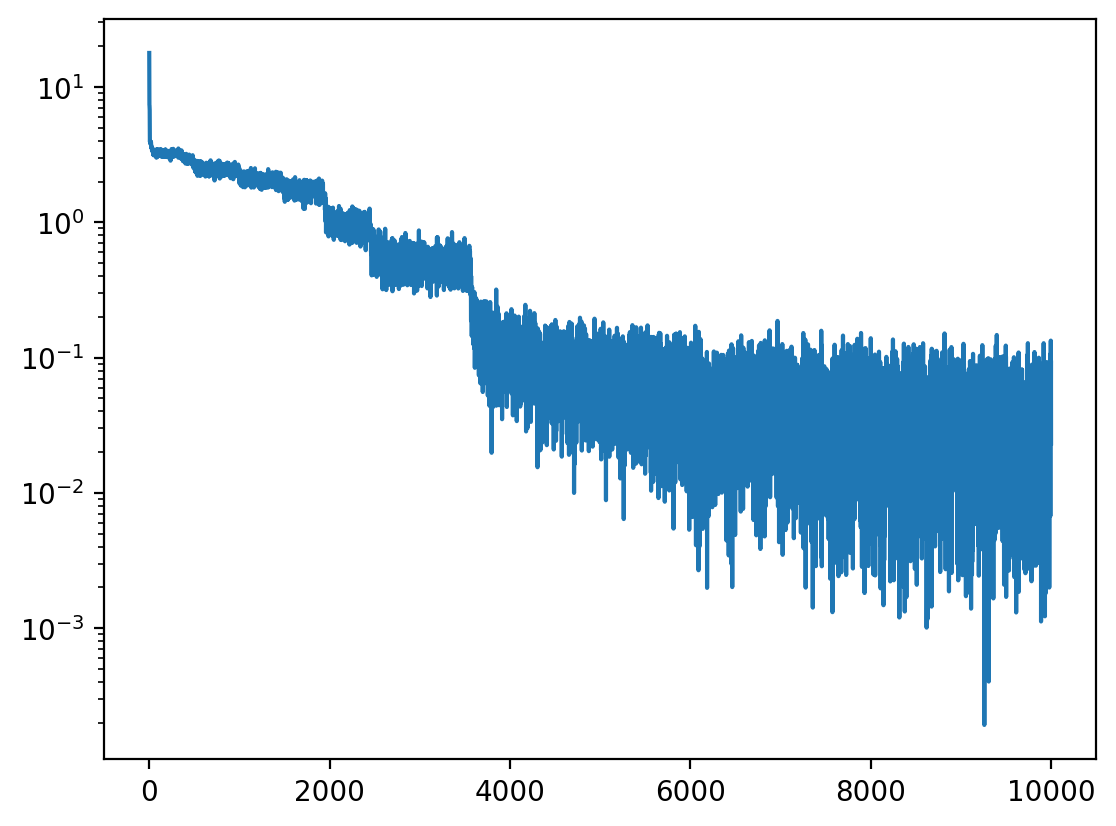

In [39]:
learning_rate = 1e-4
N_drop = 10000
gamma = 0.5
N_train = 60000
N_test = 100
N_update = 10000
N_batch = 200
N_classes = 10
N_inp = features.shape[1]
K = 2000
k = 2
key = random.PRNGKey(45)
keys = random.split(key, 3)

model = Hopfield_dense(N_inp, K, N_classes, keys[0])

#sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.adam(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))
inds = random.choice(keys[1], N_train, (N_update, N_batch))
inds_test = -random.choice(keys[1], features.shape[0] - N_train, (N_test, ))

make_step(model, features, targets, k, opt_state, optim)

losses = []
times = []
for step, n in enumerate(inds):
    start = time.time()
    loss, model, opt_state = make_step(model, features[n], targets[n], k, opt_state, optim)
    end = time.time()
    times.append(end - start)
    losses.append(loss)
times = jnp.array(times)
losses = jnp.array(losses)
accuracy = measure_accuracy(model, features, targets, inds_test, k)
print("training time", jnp.sum(times))
print("accuracy", jnp.mean(accuracy))

plt.yscale("log")
plt.plot(losses);

# $l_{\infty}$ adversarial attack

In [181]:
def adversarial_loss(noise, model, feature, target, k, eps):
    noise = eps * noise / jnp.max(jnp.abs(noise))
    prediction = model(feature + noise, k)
    loss = prediction + 1
    loss = loss.at[target].add(-2)
    loss = -jnp.sum(loss**2)
    return loss

compute_adversarial_loss_and_grads = eqx.filter_value_and_grad(adversarial_loss)

@eqx.filter_jit
def make_step_adv(noise, model, feature, target, k, eps, opt_state, optim):
    loss, grads = compute_adversarial_loss_and_grads(noise, model, feature, target, k, eps)
    updates, opt_state = optim.update(grads, opt_state, noise)
    noise = eqx.apply_updates(noise, updates)
    return loss, noise, opt_state

prediction 3
target 5


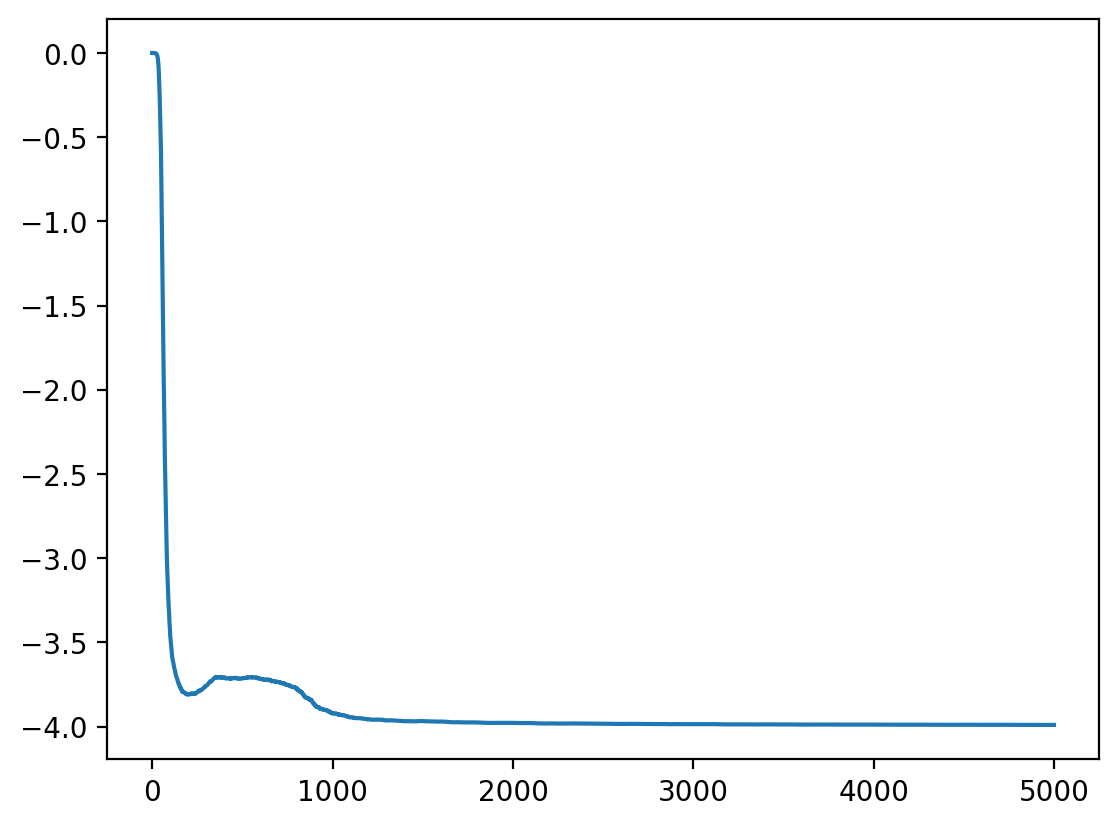

In [188]:
learning_rate = 1e-2
N_drop = 100000
gamma = 0.5
N_updates = 5000
ind = -30
eps = 1.1e-1

noise = random.normal(keys[-1], shape=(features.shape[-1],))
noise = noise / jnp.max(jnp.abs(noise))
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(noise)

losses = []
times = []
for _ in range(N_updates):
    start = time.time()
    loss, noise, opt_state = make_step_adv(noise, model, features[ind], targets[ind], k, eps, opt_state, optim)
    end = time.time()
    times.append(end - start)
    losses.append(loss)
times = jnp.array(times)
losses = jnp.array(losses)
plt.plot(losses)

prediction = predict(model, features[ind] + eps * noise / jnp.max(jnp.abs(noise)), k)
print("prediction", prediction)
print("target", targets[ind])

prediction 3


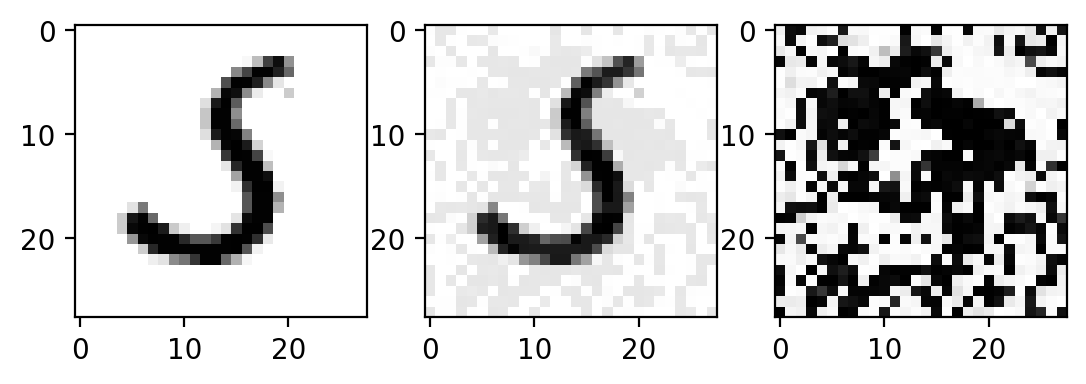

In [189]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(features[ind].reshape(28, 28), cmap='binary')
ax[1].imshow((features[ind] + eps * noise / jnp.max(jnp.abs(noise))).reshape(28, 28), cmap='binary')
ax[2].imshow((eps * noise / jnp.max(jnp.abs(noise))).reshape(28, 28), cmap='binary');

prediction = predict(model, features[ind] + eps * noise / jnp.max(jnp.abs(noise)), k)
print("prediction", prediction)

prediction 3
target 3


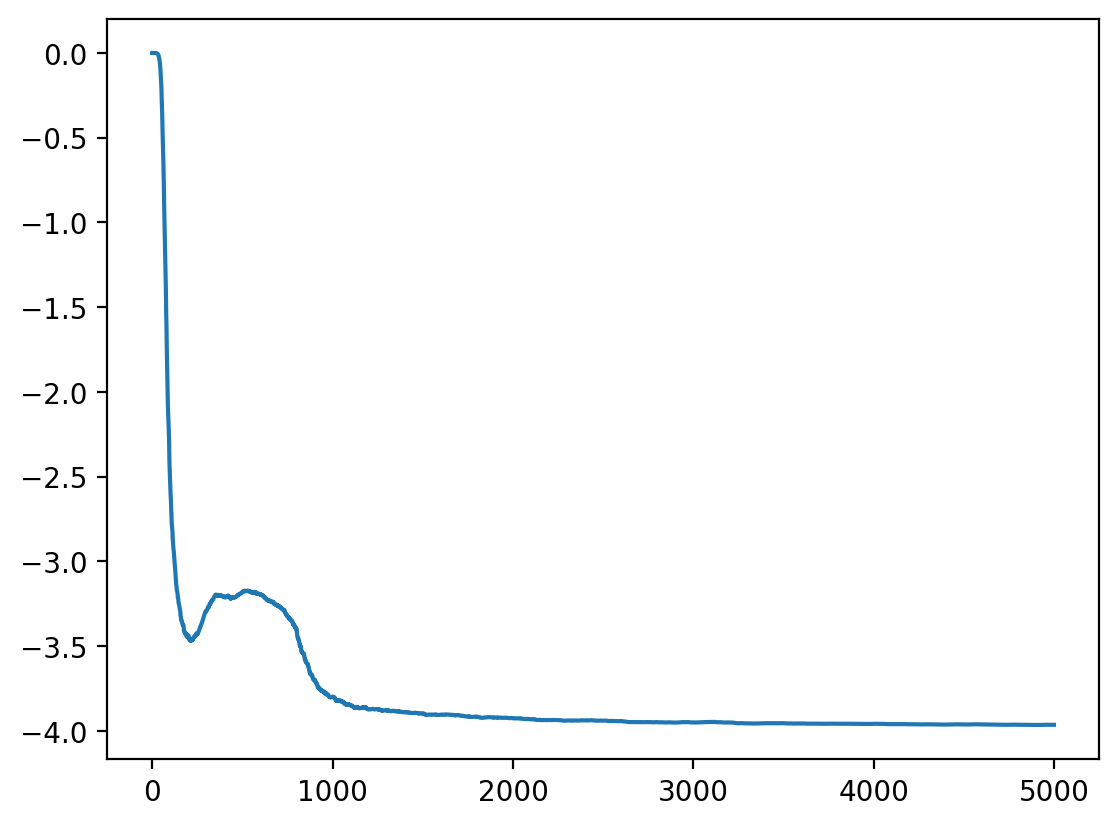

In [190]:
learning_rate = 1e-2
N_drop = 100000
gamma = 0.5
N_updates = 5000
ind = -14
eps = 1.1e-1

noise = random.normal(keys[-1], shape=(features.shape[-1],))
noise = noise / jnp.max(jnp.abs(noise))
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(noise)

losses = []
times = []
for _ in range(N_updates):
    start = time.time()
    loss, noise, opt_state = make_step_adv(noise, model, features[ind], targets[ind], k, eps, opt_state, optim)
    end = time.time()
    times.append(end - start)
    losses.append(loss)
times = jnp.array(times)
losses = jnp.array(losses)
plt.plot(losses)

prediction = predict(model, features[ind] + eps * noise / jnp.max(jnp.abs(noise)), k)
print("prediction", prediction)
print("target", targets[ind])

In [192]:
model(features[ind] + eps * noise / jnp.max(jnp.abs(noise)), k)

Array([-1.        , -0.99994755, -0.9999985 , -0.99092084, -1.        ,
       -1.        , -1.        , -1.        , -0.99999714, -0.9974277 ],      dtype=float32)

prediction 3


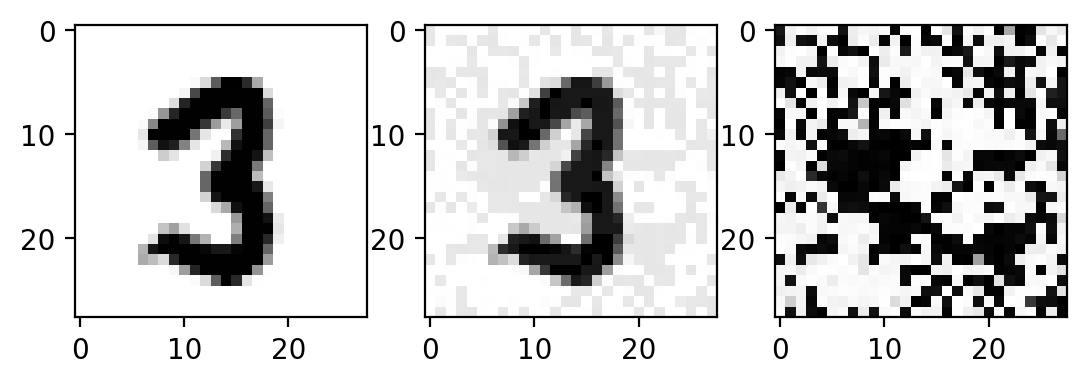

In [191]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(features[ind].reshape(28, 28), cmap='binary')
ax[1].imshow((features[ind] + eps * noise / jnp.max(jnp.abs(noise))).reshape(28, 28), cmap='binary')
ax[2].imshow((eps * noise / jnp.max(jnp.abs(noise))).reshape(28, 28), cmap='binary');

prediction = predict(model, features[ind] + eps * noise / jnp.max(jnp.abs(noise)), k)
print("prediction", prediction)

# $l_{\infty}$ adversarial attack (penalty)

In [127]:
def adversarial_loss(noise, model, feature, target, k, eps):
    prediction = model(feature + noise, k)
    loss = prediction + 1
    loss = loss.at[target].add(-2)
    loss = -jnp.sum(loss**2) + eps * jnp.sum(jnp.abs(noise))
    return loss

compute_adversarial_loss_and_grads = eqx.filter_value_and_grad(adversarial_loss)

@eqx.filter_jit
def make_step_adv(noise, model, feature, target, k, eps, opt_state, optim):
    loss, grads = compute_adversarial_loss_and_grads(noise, model, feature, target, k, eps)
    updates, opt_state = optim.update(grads, opt_state, noise)
    noise = eqx.apply_updates(noise, updates)
    return loss, noise, opt_state

prediction 3
target 5


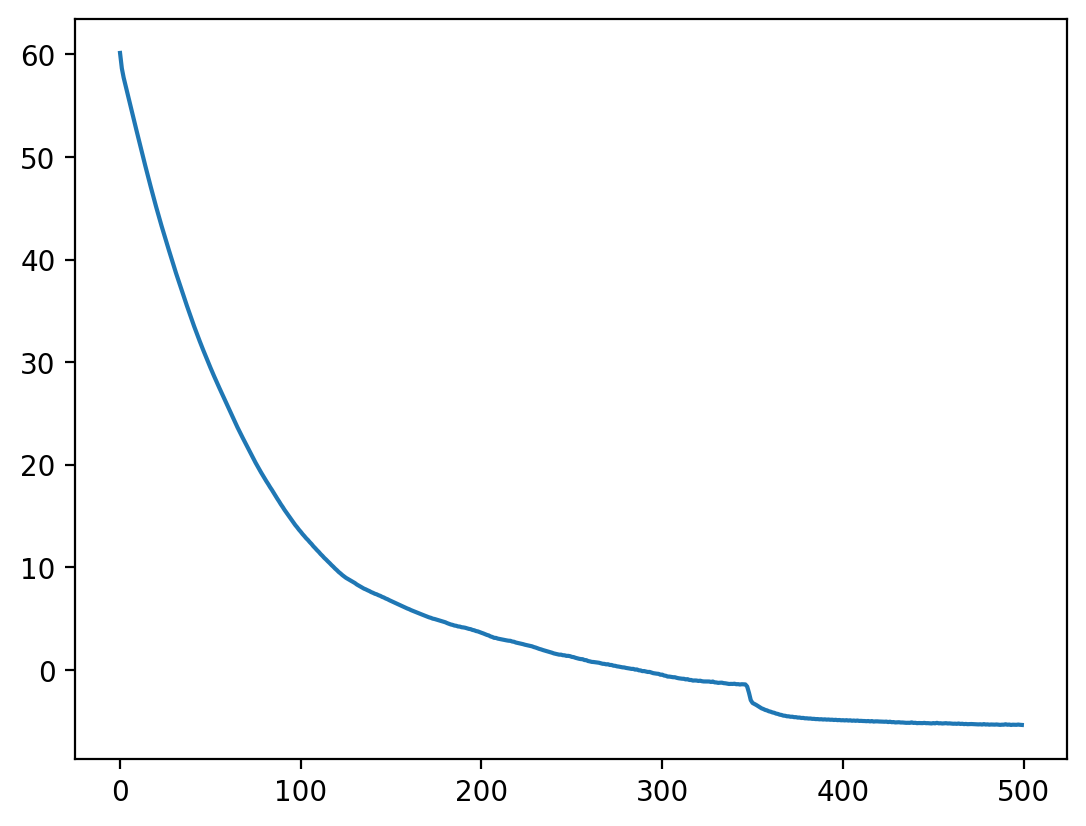

In [178]:
learning_rate = 1e-2
N_drop = 100000
gamma = 0.5
N_updates = 500
ind = -30
eps = 0.1

noise = random.normal(keys[-1], shape=(features.shape[-1],))
noise = noise
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(noise)

losses = []
times = []
for _ in range(N_updates):
    start = time.time()
    loss, noise, opt_state = make_step_adv(noise, model, features[ind], targets[ind], k, eps, opt_state, optim)
    end = time.time()
    times.append(end - start)
    losses.append(loss)
times = jnp.array(times)
losses = jnp.array(losses)
plt.plot(losses)

prediction = predict(model, features[ind] + noise, k)
print("prediction", prediction)
print("target", targets[ind])

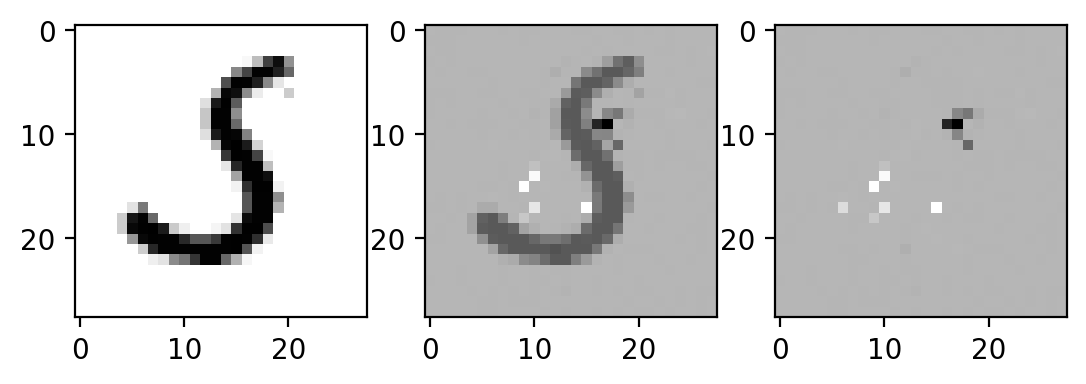

In [179]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(features[ind].reshape(28, 28), cmap='binary')
ax[1].imshow((features[ind] + noise).reshape(28, 28), cmap='binary')
ax[2].imshow(noise.reshape(28, 28), cmap='binary');

In [175]:
noise_

Array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
       -0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       , -0.       , -0.       , -0.       ,  0.       ,
        0.       , -0.       ,  0.       ,  0.       ,  0.       ,
       -0.       ,  0.       ,  0.       ,  0.       , -0.       ,
        0.       , -0.       , -0.       ,  0.       ,  0.       ,
        0.       , -0.       , -0.       , -0.       , -0.       ,
       -0.       , -0.       ,  0.       , -0.       , -0.       ,
        0.       , -0.       , -0.       , -0.       ,  0.       ,
       -0.       , -0.       ,  0.       ,  0.       , -0.       ,
       -0.       ,  0.       , -0.       ,  0.       , -0.       ,
       -0.       ,  0.       ,  0.       ,  0.       , -0.       ,
        0.       , -0.       , -0.       , -0.       ,  0.       ,
       -0.       , -0.       , -0.       , -0.       ,  0.       ,
       -0.       ,  0.       ,  0.       ,  0.       , -0.    